In [1]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# chozhang@student.ethz.ch, 22-945-562
# minghli@student.ethz.ch, 22-953-293
# changli@student.ethz.ch, 22-944-474

In [249]:
from typing import Sequence

In [2]:
import os
import sys
curr_environ = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
if curr_environ != 'Localhost': 
    sys.path.append('/kaggle/input/mobile-health-2023-path-detection')
    input_dir = '/kaggle/input/mobile-health-2023-path-detection'
else:
    input_dir = os.path.abspath('')

In [12]:
import numpy as np
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join

In [59]:
import matplotlib.pyplot as plt

In [7]:
# for signal processing and calculations
from scipy import signal

# for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [4]:
### signal processing functions ###
def parse(signal, ds_freq:float=20.0, zero_mean:bool=False):
    """downsampling the signal to specific frequency ds_freq, and make the data
     with zero mean if zero_mean is True"""
    ori_time_seq = np.array(signal.timestamps)
    ori_value_seq = np.array(signal.values)
    if zero_mean: ori_value_seq = ori_value_seq - np.mean(ori_value_seq)
    dt = 1./ds_freq
    time_seq = np.arange(start=np.min(ori_time_seq), stop=np.max(ori_time_seq), step=dt)
    value_seq = np.interp(time_seq, ori_time_seq, ori_value_seq)
    return time_seq, value_seq
    
def bp_filter(value_seq, fp:float=3, fs:float=20.0):
    """apply band pass filter to the sequence. fp is the threshold frequency,
     and fs is the sampling frequency."""
    sos = signal.butter(N=4, Wn=[0.5,fp], btype='bandpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, value_seq)
    return filtered
    
def get_envelop(value_seq, 
                fs:float=20, 
                half_window_size:float=0.5, 
                _min:float=20., 
                _max:float=500.):
    """
    get the envelop as the adaptive local norm of the signal, currently the mode
     of vector (no negative values). The envelop is calculated by the maximum in
     a window, half_window_size is the seconds of time. _min and _max for clip.
    """
    half_win = int(fs*half_window_size)
    seq = np.concatenate([np.zeros((half_win,)),value_seq,np.zeros((half_win,))])
    envelop = np.array([np.max(seq[k-half_win:k+half_win+1]) 
                        for k in range(half_win,half_win+len(value_seq))])
    return np.clip(envelop, _min, _max)

# Tasks

## Step Count

In [5]:
class StepCounter(BaseEstimator):
    def __init__(self, acc_min=2.,  acc_max=3., acc_height=0.25,
                 gyro_min=20., gyro_max=500., gyro_height=0.5,
                 acc_weight=1.0, half_window_size=0.5, width=0.5):
        self.acc_min = acc_min
        self.acc_max = acc_max
        self.acc_height = acc_height
        self.gyro_min = gyro_min
        self.gyro_max = gyro_max
        self.gyro_height = gyro_height
        self.acc_weight = acc_weight
        self.half_window_size = half_window_size
        self.width = width

    def fit(self, data, labels):
        # no learning actually, just to fit the estimator interface
        return self

    def score(self, X, y_true, sample_weight=None, normalize=True) -> float:
        '''
        Get the "score" of the step counting result. 
        The score is calculated based on how different the step count is from the true values
        '''
        y_predicted = self.predict(X)
        diff = y_predicted - y_true
        scores = np.zeros(len(diff))
        for i in range(len(diff)):
            s = - abs(diff[i])
            scores[i] = s
        if normalize:
            return np.average(scores, weights=sample_weight)
        elif sample_weight is not None:
            return np.dot(scores, sample_weight)
        else:
            return scores.sum()

    def predict(self, traces):
        # assume array
        if hasattr(traces, '__len__'):
            res = np.zeros(len(traces), dtype=int)
            _traces = traces
        else:
            res = np.zeros(1, dtype=int)
            _traces = [traces]
        i = 0
        for trace in _traces:
            data = trace.data
            # accelerator data
            ax, ay, az = data['ax'], data['ay'], data['az']
            # gyroscope data
            gx, gy, gz = data['gx'], data['gy'], data['gz']
            acc_step_counts = self._count_steps(ax, ay, az,
                                                _max=self.acc_max,
                                                _min=self.acc_min,
                                                _height=self.acc_height,
                                                half_window_size=self.half_window_size,
                                                width=self.width)
            gyro_step_counts = 0
            if self.acc_weight != 1.0:
                gyro_step_counts = self._count_steps(gx, gy, gz,
                                                    _max=self.gyro_max,
                                                    _min=self.gyro_min,
                                                    _height=self.gyro_height,
                                                    half_window_size=self.half_window_size,
                                                    width=self.width)
            res[i] = int(self.acc_weight * acc_step_counts +
                         (1.0 - self.acc_weight) * gyro_step_counts)
            i += 1
        if len(res) == 1:
            return res[0]
        else:
            return res

    def _count_steps(self, ax, ay, az, _max, _min, _height,
                     half_window_size=0.5, width=0.5):
        # interval of m and temp: 80ms; others 50ms
        # acc are in unit "g". gyro should be within -255, 255
        g_t, gx_v = parse(ax)  # use acceleration seems better.
        _, gy_v = parse(ay)
        _, gz_v = parse(az)

        # calculate the mode.
        g_v = np.sqrt(np.sum(np.square([gx_v, gy_v, gz_v]), axis=0))
        g_v /= get_envelop(g_v,
                           half_window_size=half_window_size,
                           _min=_min,
                           _max=_max)  # an adaptive local norm
        # band pass
        filtered_gv = bp_filter(g_v)
        # amp 1/4 after filtering, should be amplified 4x.
        filtered_gv = filtered_gv * (filtered_gv > 0) * 4

        # 0.5 optimal for gyro. not tuned for acc but I am lazy.
        peaks, _ = signal.find_peaks(filtered_gv,
                                     height=_height,
                                     distance=20 * 0.2)
        # when _min=20 for acc, height=0.01 looks good. sota: _min=1, height=0.25
        step_count = len(peaks)  # peaks are the steps.
        return step_count


---

## Smart Watch Location

According to [Kuntze et. al.](https://kaikunze.de/papers/pdf/kunze2005recognizing.pdf) it's sufficient to use a C4.5 decision tree + accelometer to do watch loc detection. (But that paper is very rudimentary)

Also [ref1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4510470/), [ref2](https://sophiabano.github.io/allpublications/images/pdfs/PETRA2019.pdf)

Building on prior work [23], raw accelerometer data were converted to signal magnitude vector values ( $SM=\sqrt{acc^2_x+acc^2_y+acc^2_z}$), thus removing the dependence of the resulting signal from the orientation of the sensor. Mean and standard deviation of the SM were considered jointly with a time-frequency analysis of SM in each 10-s window. The analysis of power spectral density aimed at characterizing the following:

1. The total power in the frequencies between 0.3 Hz and 15 Hz;
2. The first and second dominant frequencies and their powers in the same frequency band;
3. The dominant frequency in the 0.6–2.5 Hz band and its power;
4. The ratio between the power of the first dominant frequency and the total power (0.3–15 Hz);
5. The ratio between the dominant frequency of the current window and the previous window;
6. The ratio (R1) between the power at frequencies lower than 3 Hz and the total power (0.3–15 Hz);
7. The ratio (R2) between the power at frequencies lower than 3 Hz and the total power (0.3–15 Hz);
8. The ratio (R3) between the power at frequencies in the 1.5–2.5 Hz range and the total power (0.3–15 Hz).

In [126]:
dir_pig_traces = '/kaggle/input/mham-task2-submission'
pig_traces_fnames = [join(dir_pig_traces, f)
                     for f in listdir(dir_pig_traces) if isfile(join(dir_pig_traces, f))]
pig_traces_fnames.sort()
pig_traces = [Recording(t, no_labels=False, mute=True)
              for t in pig_traces_fnames]

In [185]:
from scipy.integrate import simpson
from scipy.fft import rfft, rfftfreq

In [335]:
a_trace = pig_traces[0]
a_datum = a_trace.data
a_label = a_trace.labels
ax, ay, az = a_datum['ax'], a_datum['ay'], a_datum['az']

In [366]:
a_label

{'board_loc': 0,
 'path_idx': 0,
 'activities': [1],
 'gender': 'm',
 'body_height': 186,
 'legi': '22-945-562'}

In [372]:
def compute_sm(data: Recording):
    a_datum = data.data
    ax, ay, az = a_datum['ax'], a_datum['ay'], a_datum['az']
    sm = np.sqrt(np.array(ax.values) ** 2 +
             np.array(ay.values) ** 2 +
             np.array(az.values) ** 2)
    # normalize sm
    normalized_sm = sm - np.mean(sm)
    return normalized_sm

In [346]:
def encode_feat_vec(sm):
    WINDOW = 2000 # 10s window
    feat_vecs = []
    df1s  = []; df2s  = []; dfb2s = []
    sf = 50.0
    for i in range(0, len(sm) - WINDOW, WINDOW):
        data = sm[i:i+WINDOW]
        low1 = 0.3; high1 = 15
        low2 = 0.6; high2 = 2.5
        nperseg = 2 / low1 * sf
        freqs, psd = signal.welch(data, sf, nperseg=nperseg)
        BAND1 = np.logical_and(freqs >= low1, freqs <= high1)
        BAND2 = np.logical_and(freqs >= low2, freqs <= high2)
        freq_res = freqs[1] - freqs[0]
        # compuate total power
        total_power = simpson(psd[BAND1], dx=freq_res)
        
        # compute dominant frequencies for BAND1, BAND2
        idx_p1 = psd[BAND1].argsort()[-1]
        df1 = low1 + freq_res * idx_p1
        pdf1  = simpson(psd[BAND1][idx_p1:idx_p1+2], dx=freq_res)
        df1s.append(df1)
        
        idx_p2 = psd[BAND1].argsort()[-2]
        df2 = low1 + freq_res * idx_p2
        pdf2  = simpson(psd[BAND1][idx_p2:idx_p2+2], dx=freq_res)
        df2s.append(df2)
        
        idx_b2 = psd[BAND2].argsort()[-1]
        dfb2 = low2 + freq_res * idx_b2
        pdfb2  = simpson(psd[BAND2][idx_b2:idx_b2+2], dx=freq_res)
        dfb2s.append(dfb2)
        
        ratio_pdf1_tot = pdf1 / total_power
        
        if i != 0:
            ratio_curr_prev_df1 = df1s[-1] / df1s[-2]
            ratio_curr_prev_df2 = df2s[-1] / df2s[-2]
            ratio_curr_prev_dfb2 = dfb2s[-1] / dfb2s[-2]
        else:
            ratio_curr_prev_df1, ratio_curr_prev_df2, ratio_curr_prev_dfb2 = \
                1.0, 1.0, 1.0
        
        R1 = simpson(psd[freqs <= 3], dx=freq_res) / total_power
        R2 = simpson(psd[freqs > 3], dx=freq_res) / total_power
        
        feat_vec = [
            np.mean(data), 
            np.std(data), 
            df1, pdf1, df2, pdf2, dfb2, pdfb2,
            ratio_pdf1_tot,
            ratio_curr_prev_df1, ratio_curr_prev_df2, ratio_curr_prev_dfb2,
            R1, R2]
        feat_vecs.append(feat_vec)
    return feat_vecs

In [360]:
feat_vec = np.asarray(encode_feat_vec(normalized_sm)[1:-1])

In [373]:
pig_data = [compute_sm(t) for t in pig_traces]

In [433]:
X_list = []
X = []
for pig in pig_data[:-2]:
    temp = encode_feat_vec(pig)[1:-1]
    X.extend(temp)
    X_list.append(np.asarray(temp))
y_win_list = [ [1] * len(x) for x in X_list]
y = [t.labels['board_loc'] for t in pig_traces[:-2]]

In [449]:
y_win_list[-1] = special_label
y_win = []
for y in y_win_list:
    y_win.extend(y)

In [442]:
np.array(X).shape

(983, 14)

In [450]:
len(y_win)

983

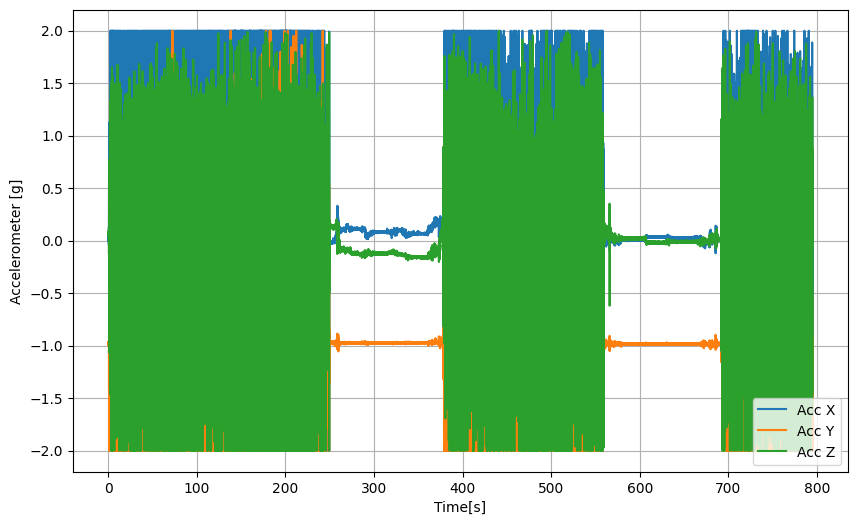

In [378]:
special_pig = pig_traces[-3]
special_pig.plot(['ax', 'ay', 'az'], 
                 ylabels=['Accelerometer [g]'], 
                 labels=['Acc X', 'Acc Y', 'Acc Z'])

In [403]:
special_sm = compute_sm(special_pig)
special_fv = np.asarray(encode_feat_vec(special_sm))[1:-1]
fv_mean = [fv[0] for fv in special_fv]
special_label = np.ones(len(special_fv))
special_label[np.where(np.asarray(fv_mean) < 0)] = 0
special_label

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [376]:
from sklearn import svm

In [384]:
clf1 = svm.SVC(C=4, gamma=0.25)

In [409]:
clf1.fit(X.transpose(), y_win_labels)

AttributeError: 'list' object has no attribute 'transpose'

In [15]:
class WatchLocPredictor(BaseEstimator):
    # required
    def __init__(self):
        pass
    
    # required
    def fit(self, data, labels):
        # first SVM to classify as walk or non-walk
        # second SVM use walk windows to classify location
        return self

    # required
    def predict(self, trace: Recording):
        clf1 = smv.SVC(C=4, gamma=0.25)
        return 0
    

---

## Path Index

All traces must contain GPS data, so can use this for sanity check.

In [9]:
class PathDetector(BaseEstimator):
    # required
    def __init__(self):
        pass

    # required
    def fit(self, data, labels):
        pass

    # required
    def predict(self, trace):
        return 0

---

## Activity

Activities contained in the data trace and performed for more than 60 s uninterrupted. 

Output as a list of integers: e.g., `[0, 3]` (`0`: standing still, `1`: walk, `2`: run, `3`: cycle). 

These do not need to be in the right order and they do not need to occur multiple times.

In [10]:
class ActivityPredictor(BaseEstimator):
    # required
    def __init__(self):
        pass

    # required
    def fit(self, data, labels):
        pass

    # required
    def predict(self, trace):
        pass

---

# Prediction

In [451]:
# Get the path of all traces
dir_traces = '/kaggle/input/mobile-health-2023-path-detection/data/test'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()

In [452]:
# initialize predictors
step_counter = StepCounter()

In [ ]:
# Loop through all traces and calculate the step count for each trace
solution_file = []
for filename in filenames:
    trace = Recording(filename, no_labels=True, mute=True)
    categorization_results = {'watch_loc': 0, 'path_idx': 0, 'step_count': 0, 'stand': 0, 'walk': 0, 'run': 0, 'cycle': 0}

    #
    # Your algorithm goes here
    # You can access the variable 'watch_loc' in the dictionary 'categorization_results' for example with
    # categorization_results['watch_loc'] = 1
    # Make sure, you do not use the gps data and are tolerant for missing data (see task set).
    # Your program must not crash when single smartphone data traces are missing.
    #
    categorization_results['step_count'] = step_counter.predict(trace)

    # Append your calculated results and the id of each trace and category to the solution file
    trace_id = ''.join([*filename][-8:-5])
    for counter_label, category in enumerate(categorization_results):
        solution_file.append([trace_id + f'_{counter_label+1}', categorization_results[category]])


In [ ]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Category') of the .csv file
submission_file_df = pd.DataFrame(np.asarray(solution_file), columns=['Id', 'Category'])
submission_file_df.to_csv('/kaggle/working/submission.csv', header=['Id', 'Category'], index=False)